# Loading Libraries

In [6]:
# Pandas & Numpy
import pandas as pd
import numpy as np 

# Visualization
import seaborn as sns 
from matplotlib import pyplot as plt 

# Tensorflow
import tensorflow as tf
from tensorflow import keras 

# Affinity Matrix 
from recommenders.datasets.sparse import AffinityMatrix

# Evaluation 
from recommenders.evaluation.python_evaluation import (
    precision_at_k,
    recall_at_k,
    ndcg_at_k,
    map_at_k
)
from sklearn.metrics import accuracy_score 

# Recomender Utilities
from recommenders.utils.timer import Timer
from recommenders.utils.constants import SEED as DEFAULT_SEED
from recommenders.utils.python_utils import binarize
from recommenders.datasets.python_splitters import numpy_stratified_split
from recommenders.datasets.split_utils import min_rating_filter_pandas

# Standard VAE Model
#from recommenders.models.vae.standard_vae import StandardVAE

# System & OS
import sys
import os

# Import & Read Dataset

In [7]:
# Read Train & Test Data
train = pd.read_csv("../../00_Data/online_retail_train_mixed.csv", index_col=0)
test = pd.read_csv("../../00_Data/online_retail_test_mixed.csv", index_col=0)

In [8]:
# Check Shapes
print("Shape of Train:", train.shape)
print("Shape of Test: \t", test.shape)

Shape of Train: (287957, 3)
Shape of Test: 	 (71990, 3)


In [9]:
# Check Number of Unique Items and User in Train & Test 
print("Unique Users in Train:", train.CustomerID.nunique())
print("Unique Users in Test:", test.CustomerID.nunique())
print("Unique Items in Train:", train.StockCode.nunique())
print("Unique Items in Test:", test.StockCode.nunique())

Unique Users in Train: 3694
Unique Users in Test: 3694
Unique Items in Train: 2786
Unique Items in Test: 2786


In [10]:
# Concatenate both Dataset again for further Data Preparation
df = pd.concat([train, test], axis=0)

In [11]:
# Change name of columns 
df = df.rename(columns={'StockCode':'itemID', 'CustomerID':'userID', 'purchased':'rating'})
df.columns

Index(['itemID', 'userID', 'rating'], dtype='object')

# Data Filtering 

In [12]:
# Binarize the data (only keep ratings >= 0.5)
df_preferred = df[df['rating'] > 0.5]
print (df_preferred.shape)
df_low_rating = df[df['rating'] <= 0.5]


# Head of df_preferred
df_preferred.head(10)

(259350, 3)


,itemID,userID,rating
171197,1917,441,1
219802,2369,145,1
239431,2855,4208,1
21619,386,3864,1
148454,1696,67,1
62494,925,2075,1
66142,976,3192,1
55056,870,2290,1
256582,3280,1009,1
51203,829,516,1


In [13]:
# Head of df_low_rating
df_low_rating.head(10)

,itemID,userID,rating
296882,2016,1620,0
262509,673,124,0
316340,1194,2475,0
346006,341,3758,0
307927,946,2099,0
335208,953,3290,0
355636,1130,4173,0
343479,3111,3645,0
318219,940,2564,0
348929,1394,3886,0


In [14]:
# Keep users who clicked on at least 5 items
df = min_rating_filter_pandas(df_preferred, min_rating=5, filter_by="user")

# Keep movies that were clicked on by at least on 1 user
df = min_rating_filter_pandas(df, min_rating=1, filter_by="item")

In [15]:
# Obtain both usercount and itemcount after filtering
usercount = df[['userID']].groupby('userID', as_index = False).size()
itemcount = df[['itemID']].groupby('itemID', as_index = False).size()

# Compute sparsity after filtering
sparsity = 1. * df.shape[0] / (usercount.shape[0] * itemcount.shape[0])

print("After filtering, there are %d interactions between %d users and %d items (sparsity: %.3f%%)" % 
      (df.shape[0], usercount.shape[0], itemcount.shape[0], sparsity * 100))

After filtering, there are 259350 interactions between 3694 users and 2786 items (sparsity: 2.520%)


# Split Data

In [16]:
unique_users = sorted(df.userID.unique())
np.random.seed(1)
unique_users = np.random.permutation(unique_users)

In [17]:
# Create train/validation/test users
n_users = len(unique_users)
print("Number of unique users:", n_users)

train_users = unique_users[:(n_users - 750 * 2)]
print("\nNumber of training users:", len(train_users))

val_users = unique_users[(n_users - 750 * 2) : (n_users - 750)]
print("\nNumber of validation users:", len(val_users))

test_users = unique_users[(n_users - 750):]
print("\nNumber of test users:", len(test_users))

Number of unique users: 3694

Number of training users: 2194

Number of validation users: 750

Number of test users: 750


In [18]:
# For training set keep only users that are in train_users list
train_set = df.loc[df['userID'].isin(train_users)]
print("Number of training observations: ", train_set.shape[0])

# For validation set keep only users that are in val_users list
val_set = df.loc[df['userID'].isin(val_users)]
print("\nNumber of validation observations: ", val_set.shape[0])

# For test set keep only users that are in test_users list
test_set = df.loc[df['userID'].isin(test_users)]
print("\nNumber of test observations: ", test_set.shape[0])


Number of training observations:  155175

Number of validation observations:  54081

Number of test observations:  50094


In [19]:
# Obtain list of unique items used in training set
unique_train_items = pd.unique(train_set['itemID'])
print("Number of unique items that consumed in training set", unique_train_items.size)

Number of unique items that consumed in training set 2786


In [20]:
# For validation set keep only items that used in training set
val_set = val_set.loc[val_set['itemID'].isin(unique_train_items)]
print("Number of validation observations after filtering: ", val_set.shape[0])

# For test set keep only movies items used in training set
test_set = test_set.loc[test_set['itemID'].isin(unique_train_items)]
print("\nNumber of test observations after filtering: ", test_set.shape[0])

Number of validation observations after filtering:  54081

Number of test observations after filtering:  50094


In [21]:
test_set.shape[0] / (train_set.shape[0] + val_set.shape[0] + test_set.shape[0])

0.1931521110468479

# Click Matrix Generation

In [22]:
# Instantiate the sparse matrix generation for train, validation and test sets
# use list of unique items from training set for all sets
am_train = AffinityMatrix(df=train_set, items_list=unique_train_items)

am_val = AffinityMatrix(df=val_set, items_list=unique_train_items)

am_test = AffinityMatrix(df=test_set, items_list=unique_train_items)

In [23]:
# Obtain the sparse matrix for train, validation and test sets
train_data, _, _ = am_train.gen_affinity_matrix()
print(train_data.shape)

val_data, val_map_users, val_map_items = am_val.gen_affinity_matrix()
print(val_data.shape)

test_data, test_map_users, test_map_items = am_test.gen_affinity_matrix()
print(test_data.shape)

(2194, 2786)
(750, 2786)
(750, 2786)


In [24]:
# Split validation and test data into training and testing parts
val_data_tr, val_data_te = numpy_stratified_split(val_data, ratio=0.75, seed=1)
test_data_tr, test_data_te = numpy_stratified_split(test_data, ratio=0.75, seed=1)

In [25]:
# Binarize train, validation and test data
train_data = binarize(a=train_data, threshold=0.5)
val_data = binarize(a=val_data, threshold=0.5)
test_data = binarize(a=test_data, threshold=0.5)

In [26]:
# Binarize validation data: training part  
val_data_tr = binarize(a=val_data_tr, threshold=0.5)

# Binarize validation data: testing part (save non-binary version in the separate object, will be used for calculating NDCG)
val_data_te_ratings = val_data_te.copy()
val_data_te = binarize(a=val_data_te, threshold=0.5)

In [27]:
# Binarize test data: training part 
test_data_tr = binarize(a=test_data_tr, threshold=0.5)

# Binarize test data: testing part (save non-binary version in the separate object, will be used for calculating NDCG)
test_data_te_ratings = test_data_te.copy()
test_data_te = binarize(a=test_data_te, threshold=0.5)

In [28]:
# retrieve real ratings from initial dataset 

test_data_te_ratings=pd.DataFrame(test_data_te_ratings)
val_data_te_ratings=pd.DataFrame(val_data_te_ratings)

for index,i in df_low_rating.iterrows():
  user_old= i['userID'] # old value 
  item_old=i['itemID'] # old value 

  if (test_map_users.get(user_old) is not None)  and (test_map_items.get(item_old) is not None) :
      user_new=test_map_users.get(user_old) # new value 
      item_new=test_map_items.get(item_old) # new value 
      rating=i['rating'] 
      test_data_te_ratings.at[user_new,item_new]= rating   

  if (val_map_users.get(user_old) is not None)  and (val_map_items.get(item_old) is not None) :
      user_new=val_map_users.get(user_old) # new value 
      item_new=val_map_items.get(item_old) # new value 
      rating=i['rating'] 
      val_data_te_ratings.at[user_new,item_new]= rating   


val_data_te_ratings=val_data_te_ratings.to_numpy()    
test_data_te_ratings=test_data_te_ratings.to_numpy()    

In [35]:
df.rating.value_counts()

1    259350
Name: rating, dtype: int64

In [40]:
test_data_tr.shape

(750, 2786)

In [46]:
np.unique(train_data)

array([0., 1.])

# Update Source Code of Recommenders

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, Callback

from recommenders.evaluation.python_evaluation import ndcg_at_k


class LossHistory(Callback):
    """This class is used for saving the validation loss and the training loss per epoch."""

    def on_train_begin(self, logs={}):
        """Initialise the lists where the loss of training and validation will be saved."""
        self.losses = []
        self.val_losses = []


    def on_epoch_end(self, epoch, logs={}):
        """Save the loss of training and validation set at the end of each epoch."""
        self.losses.append(logs.get("loss"))
        self.val_losses.append(logs.get("val_loss"))



class Metrics(Callback):
    """Callback function used to calculate the NDCG@k metric of validation set at the end of each epoch.
    Weights of the model with the highest NDCG@k value is saved."""

    def __init__(self, model, val_tr, val_te, mapper, k, save_path=None):

        """Initialize the class parameters.

        Args:
            model: trained model for validation.
            val_tr (numpy.ndarray, float): the click matrix for the validation set training part.
            val_te (numpy.ndarray, float): the click matrix for the validation set testing part.
            mapper (AffinityMatrix): the mapper for converting click matrix to dataframe.
            k (int): number of top k items per user (optional).
            save_path (str): Default path to save weights.
        """
        # Model
        self.model = model

        # Initial value of NDCG
        self.best_ndcg = 0.0

        # Validation data: training and testing parts
        self.val_tr = val_tr
        self.val_te = val_te

        # Mapper for converting from sparse matrix to dataframe
        self.mapper = mapper

        # Top k items to recommend
        self.k = k

        # Options to save the weights of the model for future use
        self.save_path = save_path


    def on_train_begin(self, logs={}):
        """Initialise the list for validation NDCG@k."""
        self._data = []


    def recommend_k_items(self, x, k, remove_seen=True):
        """Returns the top-k items ordered by a relevancy score.
        Obtained probabilities are used as recommendation score.

        Args:
            x (numpy.ndarray, int32): input click matrix.
            k (scalar, int32): the number of items to recommend.

        Returns:
            numpy.ndarray: A sparse matrix containing the top_k elements ordered by their score.

        """
        # obtain scores
        score = self.model.predict(x)

        if remove_seen:
            # if true, it removes items from the train set by setting them to zero
            seen_mask = np.not_equal(x, 0)
            score[seen_mask] = 0

        # get the top k items
        top_items = np.argpartition(-score, range(k), axis=1)[:, :k]

        # get a copy of the score matrix
        score_c = score.copy()

        # set to zero the k elements
        score_c[np.arange(score_c.shape[0])[:, None], top_items] = 0

        # set to zeros all elements other then the k
        top_scores = score - score_c

        return top_scores


    def on_epoch_end(self, batch, logs={}):
        """At the end of each epoch calculate NDCG@k of the validation set.
        If the model performance is improved, the model weights are saved.
        Update the list of validation NDCG@k by adding obtained value.
        """
        # recommend top k items based on training part of validation set
        top_k = self.recommend_k_items(x=self.val_tr, k=self.k, remove_seen=True)

        # convert recommendations from sparse matrix to dataframe
        top_k_df = self.mapper.map_back_sparse(top_k, kind="prediction")
        test_df = self.mapper.map_back_sparse(self.val_te, kind="ratings")

        # calculate NDCG@k
        NDCG = ndcg_at_k(test_df, top_k_df, col_prediction="prediction", k=self.k)

        # check if there is an improvement in NDCG, if so, update the weights of the saved model
        if NDCG > self.best_ndcg:
            self.best_ndcg = NDCG

            # save the weights of the optimal model
            if self.save_path is not None:
                self.model.save(self.save_path)

        self._data.append(NDCG)


    def get_data(self):
        """Returns a list of the NDCG@k of the validation set metrics calculated
        at the end of each epoch."""
        return self._data



class AnnealingCallback(Callback):
    """This class is used for updating the value of β during the annealing process.
    When β reaches the value of anneal_cap, it stops increasing.
    """

    def __init__(self, beta, anneal_cap, total_anneal_steps):

        """Constructor

        Args:
            beta (float): current value of beta.
            anneal_cap (float): maximum value that beta can reach.
            total_anneal_steps (int): total number of annealing steps.
        """
        # maximum value that beta can take
        self.anneal_cap = anneal_cap

        # initial value of beta
        self.beta = beta

        # update_count used for calculating the updated value of beta
        self.update_count = 0

        # total annealing steps
        self.total_anneal_steps = total_anneal_steps


    def on_train_begin(self, logs={}):
        """Initialise a list in which the beta value will be saved at the end of each epoch."""
        self._beta = []


    def on_batch_end(self, epoch, logs={}):
        """At the end of each batch the beta should is updated until it reaches the values of anneal cap."""
        self.update_count = self.update_count + 1

        new_beta = min(
            1.0 * self.update_count / self.total_anneal_steps, self.anneal_cap
        )

        K.set_value(self.beta, new_beta)


    def on_epoch_end(self, epoch, logs={}):
        """At the end of each epoch save the value of beta in _beta list."""
        tmp = K.eval(self.beta)
        self._beta.append(tmp)


    def get_data(self):
        """Returns a list of the beta values per epoch."""
        return self._beta



class StandardVAE:
    """Standard Variational Autoencoders (VAE) for Collaborative Filtering implementation."""

    def __init__(
        self,
        n_users,
        original_dim,
        intermediate_dim=200,
        latent_dim=70,
        n_epochs=400,
        batch_size=100,
        k=100,
        verbose=1,
        drop_encoder=0.5,
        drop_decoder=0.5,
        beta=1.0,
        annealing=False,
        anneal_cap=1.0,
        seed=None,
        save_path=None,
    ):

        """Initialize class parameters.

        Args:
            n_users (int): Number of unique users in the train set.
            original_dim (int): Number of unique items in the train set.
            intermediate_dim (int): Dimension of intermediate space.
            latent_dim (int): Dimension of latent space.
            n_epochs (int): Number of epochs for training.
            batch_size (int): Batch size.
            k (int): number of top k items per user.
            verbose (int): Whether to show the training output or not.
            drop_encoder (float): Dropout percentage of the encoder.
            drop_decoder (float): Dropout percentage of the decoder.
            beta (float): a constant parameter β in the ELBO function,
                  when you are not using annealing (annealing=False)
            annealing (bool): option of using annealing method for training the model (True)
                  or not using annealing, keeping a constant beta (False)
            anneal_cap (float): maximum value that beta can take during annealing process.
            seed (int): Seed.
            save_path (str): Default path to save weights.
        """
        # Seed
        self.seed = seed
        np.random.seed(self.seed)

        # Parameters
        self.n_users = n_users
        self.original_dim = original_dim
        self.intermediate_dim = intermediate_dim
        self.latent_dim = latent_dim
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.k = k
        self.verbose = verbose

        # Compute samples per epoch
        self.number_of_batches = self.n_users // self.batch_size

        # Annealing parameters
        self.anneal_cap = anneal_cap
        self.annealing = annealing

        if self.annealing:
            self.beta = K.variable(0.0)
        else:
            self.beta = beta

        # Compute total annealing steps
        self.total_anneal_steps = (
            self.number_of_batches * (self.n_epochs - int(self.n_epochs * 0.2))
        ) // self.anneal_cap

        # Dropout parameters
        self.drop_encoder = drop_encoder
        self.drop_decoder = drop_decoder

        # Path to save optimal model
        self.save_path = save_path

        # Create StandardVAE model
        self._create_model()


    def _create_model(self):
        """Build and compile model."""
        # Encoding
        self.x = Input(shape=(self.original_dim,))
        self.dropout_encoder = Dropout(self.drop_encoder)(self.x)
        self.h = Dense(self.intermediate_dim, activation="tanh")(self.dropout_encoder)
        self.z_mean = Dense(self.latent_dim)(self.h)
        self.z_log_var = Dense(self.latent_dim)(self.h)

        # Sampling
        self.z = Lambda(self._take_sample, output_shape=(self.latent_dim,))(
            [self.z_mean, self.z_log_var]
        )

        # Decoding
        self.h_decoder = Dense(self.intermediate_dim, activation="tanh")
        self.dropout_decoder = Dropout(self.drop_decoder)
        self.x_bar = Dense(self.original_dim, activation="softmax")
        self.h_decoded = self.h_decoder(self.z)
        self.h_decoded_ = self.dropout_decoder(self.h_decoded)
        self.x_decoded = self.x_bar(self.h_decoded_)

        # Training
        self.model = Model(self.x, self.x_decoded)
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss=self._get_vae_loss,
            experimental_run_tf_function=False
        )

    def _get_vae_loss(self, x, x_bar):
        """Calculate negative ELBO (NELBO)."""
        # Reconstruction error: logistic log likelihood
        reconst_loss = self.original_dim * binary_crossentropy(x, x_bar)

        # Kullback–Leibler divergence
        kl_loss = 0.5 * K.sum(
            -1 - self.z_log_var + K.square(self.z_mean) + K.exp(self.z_log_var), axis=-1
        )

        return reconst_loss + self.beta * kl_loss

    def _take_sample(self, args):
        """Sample epsilon ∼ N (0,I) and compute z via reparametrization trick."""
        """Calculate latent vector using the reparametrization trick.
           The idea is that sampling from N (_mean, _var) is s the same as sampling from _mean+ epsilon * _var
           where epsilon ∼ N(0,I)."""
        # sampling from latent dimension for decoder/generative part of network
        _mean, _log_var = args
        epsilon = K.random_normal(
            shape=(K.shape(_mean)[0], self.latent_dim),
            mean=0.0,
            stddev=1.0,
            seed=self.seed,
        )

        return _mean + K.exp(_log_var / 2) * epsilon

    def nn_batch_generator(self, x_train):
        """Used for splitting dataset in batches.

        Args:
            x_train (numpy.ndarray): The click matrix for the train set with float values.
        """
        # Shuffle the batch
        np.random.seed(self.seed)
        shuffle_index = np.arange(np.shape(x_train)[0])
        np.random.shuffle(shuffle_index)
        x = x_train[shuffle_index, :]
        y = x_train[shuffle_index, :]

        # Iterate until making a full epoch
        counter = 0
        while 1:
            index_batch = shuffle_index[
                self.batch_size * counter : self.batch_size * (counter + 1)
            ]
            # Decompress batch
            x_batch = x[index_batch, :]
            y_batch = y[index_batch, :]
            counter += 1
            yield (np.array(x_batch), np.array(y_batch))

            # Stopping rule
            if counter >= self.number_of_batches:
                counter = 0


    def fit(self, x_train, x_valid, x_val_tr, x_val_te, mapper):
        """Fit model with the train sets and validate on the validation set.

        Args:
            x_train (numpy.ndarray): The click matrix for the train set.
            x_valid (numpy.ndarray): The click matrix for the validation set.
            x_val_tr (numpy.ndarray): The click matrix for the validation set training part.
            x_val_te (numpy.ndarray): The click matrix for the validation set testing part.
            mapper (object): The mapper for converting click matrix to dataframe. It can be AffinityMatrix.
        """
        # initialise LossHistory used for saving loss of validation and train set per epoch
        history = LossHistory()

        # initialise Metrics  used for calculating NDCG@k per epoch
        # and saving the model weights with the highest NDCG@k value
        metrics = Metrics(
            model=self.model,
            val_tr=x_val_tr,
            val_te=x_val_te,
            mapper=mapper,
            k=self.k,
            save_path=self.save_path,
        )

        self.reduce_lr = ReduceLROnPlateau(
            monitor="val_loss", factor=0.2, patience=1, min_lr=0.0001
        )

        if self.annealing:
            # initialise AnnealingCallback for annealing process
            anneal = AnnealingCallback(
                self.beta, self.anneal_cap, self.total_anneal_steps
            )

            # fit model
            self.model.fit(
                self.nn_batch_generator(x_train),
                steps_per_epoch=self.number_of_batches,
                epochs=self.n_epochs,
                verbose=self.verbose,
                callbacks=[metrics, history, self.reduce_lr, anneal],
                validation_data=(x_valid, x_valid),
            )

            self.ls_beta = anneal.get_data()

        else:
            self.model.fit(
                self.nn_batch_generator(x_train),
                steps_per_epoch=self.number_of_batches,
                epochs=self.n_epochs,
                verbose=self.verbose,
                callbacks=[metrics, history, self.reduce_lr],
                validation_data=(x_valid, x_valid),
            )

        # save lists
        self.train_loss = history.losses
        self.val_loss = history.val_losses
        self.val_ndcg = metrics.get_data()


    def get_optimal_beta(self):
        """Returns the value of the optimal beta."""
        # find the epoch/index that had the highest NDCG@k value
        index_max_ndcg = np.argmax(self.val_ndcg)

        # using this index find the value that beta had at this epoch
        optimal_beta = self.ls_beta[index_max_ndcg]

        return optimal_beta


    def display_metrics(self):
        """Plots:
        1) Loss per epoch both for validation and train sets
        2) NDCG@k per epoch of the validation set
        """
        # Plot setup
        plt.figure(figsize=(14, 5))
        sns.set(style="whitegrid")

        # Plot loss on the left graph
        plt.subplot(1, 2, 1)
        plt.plot(self.train_loss, color="b", linestyle="-", label="Train")
        plt.plot(self.val_loss, color="r", linestyle="-", label="Val")
        plt.title("\n")
        plt.xlabel("Epochs", size=14)
        plt.ylabel("Loss", size=14)
        plt.legend(loc="upper left")

        # Plot NDCG on the right graph
        plt.subplot(1, 2, 2)
        plt.plot(self.val_ndcg, color="r", linestyle="-", label="Val")
        plt.title("\n")
        plt.xlabel("Epochs", size=14)
        plt.ylabel("NDCG@k", size=14)
        plt.legend(loc="upper left")

        # Add title
        plt.suptitle("TRAINING AND VALIDATION METRICS HISTORY", size=16)
        plt.tight_layout(pad=2)


    def recommend_k_items(self, x, k, remove_seen=True):
        """Returns the top-k items ordered by a relevancy score.

        Obtained probabilities are used as recommendation score.

        Args:
            x (numpy.ndarray): Input click matrix, with `int32` values.
            k (scalar): The number of items to recommend.

        Returns:
            numpy.ndarray: A sparse matrix containing the top_k elements ordered by their score.

        """
        # return optimal model
        self.model.load_weights(self.save_path)

        # obtain scores
        score = self.model.predict(x)
        if remove_seen:
            # if true, it removes items from the train set by setting them to zero
            seen_mask = np.not_equal(x, 0)
            score[seen_mask] = 0
        # get the top k items
        top_items = np.argpartition(-score, range(k), axis=1)[:, :k]
        # get a copy of the score matrix
        score_c = score.copy()
        # set to zero the k elements
        score_c[np.arange(score_c.shape[0])[:, None], top_items] = 0
        # set to zeros all elements other then the k
        top_scores = score - score_c
        return top_scores


    def ndcg_per_epoch(self):
        """Returns the list of NDCG@k at each epoch."""

        return self.val_ndcg

# Baseline Model Standard VAE

In [30]:
from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()

In [31]:
from tempfile import TemporaryDirectory

tmp_dir = TemporaryDirectory()
WEIGHTS_PATH = os.path.join(tmp_dir.name, "svae_weights.hdf5")

In [198]:
model_without_anneal = StandardVAE(n_users=train_data.shape[0], # Number of unique users in the training set
                                   original_dim=train_data.shape[1], # Number of unique items in the training set
                                   intermediate_dim=200, 
                                   latent_dim=70, 
                                   n_epochs=50, 
                                   batch_size=100, 
                                   k=100,
                                   verbose=0,
                                   seed=1,
                                   drop_encoder=0.5,
                                   drop_decoder=0.5,
                                   annealing=False,
                                   beta=1.0,
                                   save_path=WEIGHTS_PATH
                                   )

In [199]:
with Timer() as t:
    model_without_anneal.fit(x_train=train_data, 
                        x_valid=val_data,
                        x_val_tr=val_data_tr, 
                        x_val_te=val_data_te_ratings, # with the original ratings 
                        mapper=am_val)
print("Took {} seconds for training.".format(t))

/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Took 50.1116 seconds for training.


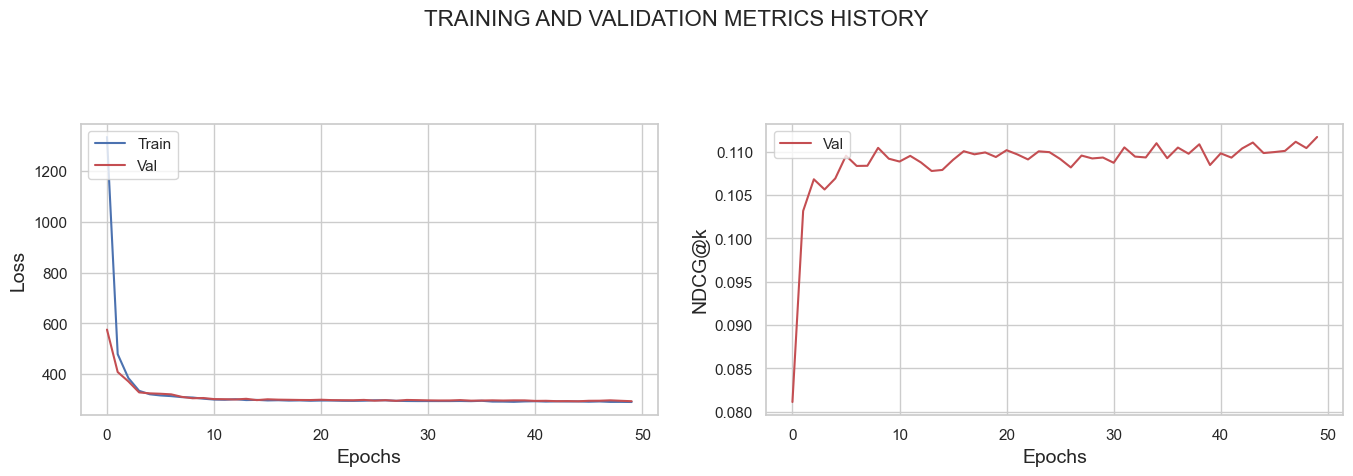

In [200]:
model_without_anneal.display_metrics() 

In [201]:
# Use k = 10
with Timer() as t:
    # Model prediction on the training part of test set 
    top_k =  model_without_anneal.recommend_k_items(x=test_data_tr,
                                                    k=10,
                                                    remove_seen=True
                                                    )

    # Convert sparse matrix back to df
    top_k_df = am_test.map_back_sparse(top_k, kind='prediction')
    test_df = am_test.map_back_sparse(test_data_te_ratings, kind='ratings') # use test_data_te_, with the original ratings
    
print("Took {} seconds for prediction.".format(t))

# Use the ranking metrics for evaluation
eval_map_1 = map_at_k(test_df, top_k_df, col_prediction='prediction', k=10)
eval_ndcg_1 = ndcg_at_k(test_df, top_k_df, col_prediction='prediction', k=10)
eval_precision_1 = precision_at_k(test_df, top_k_df, col_prediction='prediction', k=10)
eval_recall_1 = recall_at_k(test_df, top_k_df, col_prediction='prediction', k=10)

print("MAP@10:\t\t%f" % eval_map_1,
      "NDCG@10:\t%f" % eval_ndcg_1,
      "Precision@10:\t%f" % eval_precision_1,
      "Recall@10: \t%f" % eval_recall_1, sep='\n')

Took 0.3051 seconds for prediction.
MAP@10:		0.016158
NDCG@10:	0.068352
Precision@10:	0.057200
Recall@10: 	0.039989


# Hyperparameter Tuning

In [207]:
# Set up Parameters
intermediate_dimension = [200, 400, 600, 800] 
latent_dimension = [50, 70, 90] 
batch_sizes = [50, 100, 200]
anneal_status = [True, False]

# Initiate Lists for Assessment
recall_10 = []
recall_20 = []
precision_10 = []
precision_20 = []
int_dimensions = []
lt_dimensions = []
anneal = []
batch = []

for i in intermediate_dimension:
    for l in latent_dimension:
        for b in batch_sizes:
            for a in anneal_status:
                try:
                    del(model)
                except:
                    pass
                
                # Initiate Model 
                if a == True:
                    model = StandardVAE(n_users=train_data.shape[0],
                                        original_dim=train_data.shape[1],
                                        intermediate_dim=i,
                                        latent_dim=l,
                                        n_epochs=100,
                                        batch_size=b,
                                        k=100,
                                        verbose=0,
                                        seed=1,
                                        save_path=WEIGHTS_PATH,
                                        drop_encoder=0.5,
                                        drop_decoder=0.5,
                                        annealing=True,
                                        anneal_cap=1.0)
                else:
                    model = StandardVAE(n_users=train_data.shape[0], # Number of unique users in the training set
                                        original_dim=train_data.shape[1], # Number of unique items in the training set
                                        intermediate_dim=i, 
                                        latent_dim=l, 
                                        n_epochs=100, 
                                        batch_size=b, 
                                        k=100,
                                        verbose=0,
                                        seed=1,
                                        drop_encoder=0.5,
                                        drop_decoder=0.5,
                                        annealing=False,
                                        beta=1.0,
                                        save_path=WEIGHTS_PATH)
                
                # Fit model
                model.fit(x_train=train_data,
                        x_valid=val_data,
                        x_val_tr=val_data_tr,
                        x_val_te=val_data_te_ratings,
                        mapper=am_val)
            
                # Model prediction on the training part of test set K = 10  
                top_k_10 =  model.recommend_k_items(x=test_data_tr,
                                                    k=10,
                                                    remove_seen=True)

                # Convert sparse matrix back to df
                top_k_df_10 = am_test.map_back_sparse(top_k_10, kind='prediction')
                test_df = am_test.map_back_sparse(test_data_te_ratings, kind='ratings') # use test_data_te_, with the original ratings
    

                # Use the ranking metrics for evaluation
                eval_precision_10 = precision_at_k(test_df, top_k_df_10, col_prediction='prediction', k=10)
                eval_recall_10 = recall_at_k(test_df, top_k_df_10, col_prediction='prediction', k=10)

                # Print intermediate Status for Recall@10
                print("Recall@10 for Intermediate Dim: ", i, "Latent Dim: ", l, "Batch size: ", b, "Annealing: ", a, ":\t", eval_recall_10)
                
                #Model prediction on the training part of test set K = 20  
                top_k_20 =  model.recommend_k_items(x=test_data_tr,
                                                    k=20,
                                                    remove_seen=True)

                # Convert sparse matrix back to df
                top_k_df_20 = am_test.map_back_sparse(top_k_20, kind='prediction')
    

                # Use the ranking metrics for evaluation
                eval_precision_20 = precision_at_k(test_df, top_k_df_20, col_prediction='prediction', k=20)
                eval_recall_20 = recall_at_k(test_df, top_k_df_20, col_prediction='prediction', k=20)
                
                # Print intermediate Status for Recall@20
                print("Recall@20 for Intermediate Dim: ", i, "Latent Dim: ", l, "Batch size: ", b, "Annealing: ", a, ":\t", eval_recall_20)
                
                # Append Lists
                recall_10.append(eval_recall_10)
                recall_20.append(eval_recall_20)
                precision_10.append(eval_precision_10)
                precision_20.append(eval_precision_20)
                int_dimensions.append(i)
                lt_dimensions.append(l)
                anneal.append(a)
                batch.append(b) 

/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  200 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.042504311797020036
Recall@20 for Intermediate Dim:  200 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.06786685912506162


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  200 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.04451513879294252
Recall@20 for Intermediate Dim:  200 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.07319524617581925


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  200 Latent Dim:  50 Batch size:  100 Annealing:  True :	 0.04172164874607441
Recall@20 for Intermediate Dim:  200 Latent Dim:  50 Batch size:  100 Annealing:  True :	 0.06807412306265255


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  200 Latent Dim:  50 Batch size:  100 Annealing:  False :	 0.04057590077855436
Recall@20 for Intermediate Dim:  200 Latent Dim:  50 Batch size:  100 Annealing:  False :	 0.068090786583237


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  200 Latent Dim:  50 Batch size:  200 Annealing:  True :	 0.03904528299470933
Recall@20 for Intermediate Dim:  200 Latent Dim:  50 Batch size:  200 Annealing:  True :	 0.06327202935575672


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  200 Latent Dim:  50 Batch size:  200 Annealing:  False :	 0.04035732506947058
Recall@20 for Intermediate Dim:  200 Latent Dim:  50 Batch size:  200 Annealing:  False :	 0.06502097052558882


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  200 Latent Dim:  70 Batch size:  50 Annealing:  True :	 0.045906390926720914
Recall@20 for Intermediate Dim:  200 Latent Dim:  70 Batch size:  50 Annealing:  True :	 0.07502542370838199


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  200 Latent Dim:  70 Batch size:  50 Annealing:  False :	 0.04042145614957865
Recall@20 for Intermediate Dim:  200 Latent Dim:  70 Batch size:  50 Annealing:  False :	 0.06924738164654444


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  200 Latent Dim:  70 Batch size:  100 Annealing:  True :	 0.04110497030021792
Recall@20 for Intermediate Dim:  200 Latent Dim:  70 Batch size:  100 Annealing:  True :	 0.06690214794246313


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  200 Latent Dim:  70 Batch size:  100 Annealing:  False :	 0.042969948871872665
Recall@20 for Intermediate Dim:  200 Latent Dim:  70 Batch size:  100 Annealing:  False :	 0.06649513792768662


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  200 Latent Dim:  70 Batch size:  200 Annealing:  True :	 0.04004357593282813
Recall@20 for Intermediate Dim:  200 Latent Dim:  70 Batch size:  200 Annealing:  True :	 0.06645236859582339


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  200 Latent Dim:  70 Batch size:  200 Annealing:  False :	 0.04110190344166743
Recall@20 for Intermediate Dim:  200 Latent Dim:  70 Batch size:  200 Annealing:  False :	 0.06536833389913795


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  200 Latent Dim:  90 Batch size:  50 Annealing:  True :	 0.044634635623373324
Recall@20 for Intermediate Dim:  200 Latent Dim:  90 Batch size:  50 Annealing:  True :	 0.07102447057459123


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  200 Latent Dim:  90 Batch size:  50 Annealing:  False :	 0.041778732238822024
Recall@20 for Intermediate Dim:  200 Latent Dim:  90 Batch size:  50 Annealing:  False :	 0.06707770950680116


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  200 Latent Dim:  90 Batch size:  100 Annealing:  True :	 0.04096130181094847
Recall@20 for Intermediate Dim:  200 Latent Dim:  90 Batch size:  100 Annealing:  True :	 0.06708844958763369


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  200 Latent Dim:  90 Batch size:  100 Annealing:  False :	 0.04072826022739577
Recall@20 for Intermediate Dim:  200 Latent Dim:  90 Batch size:  100 Annealing:  False :	 0.0667380840769448


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  200 Latent Dim:  90 Batch size:  200 Annealing:  True :	 0.0383646917963807
Recall@20 for Intermediate Dim:  200 Latent Dim:  90 Batch size:  200 Annealing:  True :	 0.0634431434222251


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  200 Latent Dim:  90 Batch size:  200 Annealing:  False :	 0.04052325131822629
Recall@20 for Intermediate Dim:  200 Latent Dim:  90 Batch size:  200 Annealing:  False :	 0.06629108945913903


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  400 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.05964174519659398
Recall@20 for Intermediate Dim:  400 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.0984523320658759


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  400 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.061710121909930235
Recall@20 for Intermediate Dim:  400 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.10250012874330752


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  400 Latent Dim:  50 Batch size:  100 Annealing:  True :	 0.045627210956604006
Recall@20 for Intermediate Dim:  400 Latent Dim:  50 Batch size:  100 Annealing:  True :	 0.08015694093712133


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  400 Latent Dim:  50 Batch size:  100 Annealing:  False :	 0.04906001644466549
Recall@20 for Intermediate Dim:  400 Latent Dim:  50 Batch size:  100 Annealing:  False :	 0.07733797340015625


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  400 Latent Dim:  50 Batch size:  200 Annealing:  True :	 0.04076077700559416
Recall@20 for Intermediate Dim:  400 Latent Dim:  50 Batch size:  200 Annealing:  True :	 0.06714582606462861


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  400 Latent Dim:  50 Batch size:  200 Annealing:  False :	 0.041573059243987985
Recall@20 for Intermediate Dim:  400 Latent Dim:  50 Batch size:  200 Annealing:  False :	 0.06973655943325131


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  400 Latent Dim:  70 Batch size:  50 Annealing:  True :	 0.06194948187752041
Recall@20 for Intermediate Dim:  400 Latent Dim:  70 Batch size:  50 Annealing:  True :	 0.09700647670031888


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  400 Latent Dim:  70 Batch size:  50 Annealing:  False :	 0.05803736390176655
Recall@20 for Intermediate Dim:  400 Latent Dim:  70 Batch size:  50 Annealing:  False :	 0.09292196481039115


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  400 Latent Dim:  70 Batch size:  100 Annealing:  True :	 0.047018541981004136
Recall@20 for Intermediate Dim:  400 Latent Dim:  70 Batch size:  100 Annealing:  True :	 0.0754330867417979


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  400 Latent Dim:  70 Batch size:  100 Annealing:  False :	 0.04974972100481339
Recall@20 for Intermediate Dim:  400 Latent Dim:  70 Batch size:  100 Annealing:  False :	 0.07509594774918026


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  400 Latent Dim:  70 Batch size:  200 Annealing:  True :	 0.040778895865787396
Recall@20 for Intermediate Dim:  400 Latent Dim:  70 Batch size:  200 Annealing:  True :	 0.06631770116499142


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  400 Latent Dim:  70 Batch size:  200 Annealing:  False :	 0.044049411286822715
Recall@20 for Intermediate Dim:  400 Latent Dim:  70 Batch size:  200 Annealing:  False :	 0.06769457238189792


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  400 Latent Dim:  90 Batch size:  50 Annealing:  True :	 0.05885744784664114
Recall@20 for Intermediate Dim:  400 Latent Dim:  90 Batch size:  50 Annealing:  True :	 0.0943779297413817


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  400 Latent Dim:  90 Batch size:  50 Annealing:  False :	 0.05275399492319936
Recall@20 for Intermediate Dim:  400 Latent Dim:  90 Batch size:  50 Annealing:  False :	 0.08455013935359432


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  400 Latent Dim:  90 Batch size:  100 Annealing:  True :	 0.04017382291249079
Recall@20 for Intermediate Dim:  400 Latent Dim:  90 Batch size:  100 Annealing:  True :	 0.06818882302206532


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  400 Latent Dim:  90 Batch size:  100 Annealing:  False :	 0.04462652270133658
Recall@20 for Intermediate Dim:  400 Latent Dim:  90 Batch size:  100 Annealing:  False :	 0.07170970545934191


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  400 Latent Dim:  90 Batch size:  200 Annealing:  True :	 0.0403018807388248
Recall@20 for Intermediate Dim:  400 Latent Dim:  90 Batch size:  200 Annealing:  True :	 0.06637394344753206


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  400 Latent Dim:  90 Batch size:  200 Annealing:  False :	 0.04212973773299722
Recall@20 for Intermediate Dim:  400 Latent Dim:  90 Batch size:  200 Annealing:  False :	 0.06988167682043722


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  600 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.06872910510605693
Recall@20 for Intermediate Dim:  600 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.1082593582942449


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  600 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.06794131011867803
Recall@20 for Intermediate Dim:  600 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.09709989823614616


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  600 Latent Dim:  50 Batch size:  100 Annealing:  True :	 0.05506020977023489
Recall@20 for Intermediate Dim:  600 Latent Dim:  50 Batch size:  100 Annealing:  True :	 0.09418336181620582


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  600 Latent Dim:  50 Batch size:  100 Annealing:  False :	 0.05810226894744504
Recall@20 for Intermediate Dim:  600 Latent Dim:  50 Batch size:  100 Annealing:  False :	 0.09361881581092234


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  600 Latent Dim:  50 Batch size:  200 Annealing:  True :	 0.04203245701967039
Recall@20 for Intermediate Dim:  600 Latent Dim:  50 Batch size:  200 Annealing:  True :	 0.07241110356600053


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  600 Latent Dim:  50 Batch size:  200 Annealing:  False :	 0.04880202924160079
Recall@20 for Intermediate Dim:  600 Latent Dim:  50 Batch size:  200 Annealing:  False :	 0.07877166777198027


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  600 Latent Dim:  70 Batch size:  50 Annealing:  True :	 0.06598155378628569
Recall@20 for Intermediate Dim:  600 Latent Dim:  70 Batch size:  50 Annealing:  True :	 0.10432351488003813


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  600 Latent Dim:  70 Batch size:  50 Annealing:  False :	 0.06234552747582721
Recall@20 for Intermediate Dim:  600 Latent Dim:  70 Batch size:  50 Annealing:  False :	 0.09942037965190977


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  600 Latent Dim:  70 Batch size:  100 Annealing:  True :	 0.05635154868969037
Recall@20 for Intermediate Dim:  600 Latent Dim:  70 Batch size:  100 Annealing:  True :	 0.09087760258181087


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  600 Latent Dim:  70 Batch size:  100 Annealing:  False :	 0.05474813066555823
Recall@20 for Intermediate Dim:  600 Latent Dim:  70 Batch size:  100 Annealing:  False :	 0.08426030054827895


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  600 Latent Dim:  70 Batch size:  200 Annealing:  True :	 0.04260533155181343
Recall@20 for Intermediate Dim:  600 Latent Dim:  70 Batch size:  200 Annealing:  True :	 0.06988562386329661


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  600 Latent Dim:  70 Batch size:  200 Annealing:  False :	 0.04218483165946603
Recall@20 for Intermediate Dim:  600 Latent Dim:  70 Batch size:  200 Annealing:  False :	 0.06859683189813906


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  600 Latent Dim:  90 Batch size:  50 Annealing:  True :	 0.07000410511135252
Recall@20 for Intermediate Dim:  600 Latent Dim:  90 Batch size:  50 Annealing:  True :	 0.10480117150429223


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  600 Latent Dim:  90 Batch size:  50 Annealing:  False :	 0.059784217003959875
Recall@20 for Intermediate Dim:  600 Latent Dim:  90 Batch size:  50 Annealing:  False :	 0.09690681865435996


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  600 Latent Dim:  90 Batch size:  100 Annealing:  True :	 0.05472295747985824
Recall@20 for Intermediate Dim:  600 Latent Dim:  90 Batch size:  100 Annealing:  True :	 0.0854094353858649


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  600 Latent Dim:  90 Batch size:  100 Annealing:  False :	 0.052137956456786906
Recall@20 for Intermediate Dim:  600 Latent Dim:  90 Batch size:  100 Annealing:  False :	 0.0859441717752741


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  600 Latent Dim:  90 Batch size:  200 Annealing:  True :	 0.04162078083838321
Recall@20 for Intermediate Dim:  600 Latent Dim:  90 Batch size:  200 Annealing:  True :	 0.06913017754745336


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  600 Latent Dim:  90 Batch size:  200 Annealing:  False :	 0.04142306578801615
Recall@20 for Intermediate Dim:  600 Latent Dim:  90 Batch size:  200 Annealing:  False :	 0.0695032339066239


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  800 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.08367424928406528
Recall@20 for Intermediate Dim:  800 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.12885419246755378


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  800 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.07233625780529916
Recall@20 for Intermediate Dim:  800 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.11557083156871875


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  800 Latent Dim:  50 Batch size:  100 Annealing:  True :	 0.06568289477916706
Recall@20 for Intermediate Dim:  800 Latent Dim:  50 Batch size:  100 Annealing:  True :	 0.1053563904966195


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  800 Latent Dim:  50 Batch size:  100 Annealing:  False :	 0.059620288105879764
Recall@20 for Intermediate Dim:  800 Latent Dim:  50 Batch size:  100 Annealing:  False :	 0.09849025916469642


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  800 Latent Dim:  50 Batch size:  200 Annealing:  True :	 0.055450860315540675
Recall@20 for Intermediate Dim:  800 Latent Dim:  50 Batch size:  200 Annealing:  True :	 0.08331392097470877


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  800 Latent Dim:  50 Batch size:  200 Annealing:  False :	 0.05219009749440385
Recall@20 for Intermediate Dim:  800 Latent Dim:  50 Batch size:  200 Annealing:  False :	 0.08115511684635303


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  800 Latent Dim:  70 Batch size:  50 Annealing:  True :	 0.07492400205657614
Recall@20 for Intermediate Dim:  800 Latent Dim:  70 Batch size:  50 Annealing:  True :	 0.11958857713870165


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  800 Latent Dim:  70 Batch size:  50 Annealing:  False :	 0.07038518033989165
Recall@20 for Intermediate Dim:  800 Latent Dim:  70 Batch size:  50 Annealing:  False :	 0.11674955943825577


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  800 Latent Dim:  70 Batch size:  100 Annealing:  True :	 0.060054648558031686
Recall@20 for Intermediate Dim:  800 Latent Dim:  70 Batch size:  100 Annealing:  True :	 0.09702148718945171


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  800 Latent Dim:  70 Batch size:  100 Annealing:  False :	 0.06505477842381278
Recall@20 for Intermediate Dim:  800 Latent Dim:  70 Batch size:  100 Annealing:  False :	 0.09431594287400188


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  800 Latent Dim:  70 Batch size:  200 Annealing:  True :	 0.05012824920116808
Recall@20 for Intermediate Dim:  800 Latent Dim:  70 Batch size:  200 Annealing:  True :	 0.0819105795849455


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  800 Latent Dim:  70 Batch size:  200 Annealing:  False :	 0.04289763975229558
Recall@20 for Intermediate Dim:  800 Latent Dim:  70 Batch size:  200 Annealing:  False :	 0.07356060078662413


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  800 Latent Dim:  90 Batch size:  50 Annealing:  True :	 0.07955544920194427
Recall@20 for Intermediate Dim:  800 Latent Dim:  90 Batch size:  50 Annealing:  True :	 0.12302148629656305


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  800 Latent Dim:  90 Batch size:  50 Annealing:  False :	 0.0763597136638146
Recall@20 for Intermediate Dim:  800 Latent Dim:  90 Batch size:  50 Annealing:  False :	 0.11768783581807597


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  800 Latent Dim:  90 Batch size:  100 Annealing:  True :	 0.062077553231776744
Recall@20 for Intermediate Dim:  800 Latent Dim:  90 Batch size:  100 Annealing:  True :	 0.09866603469371694


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  800 Latent Dim:  90 Batch size:  100 Annealing:  False :	 0.06260764549473906
Recall@20 for Intermediate Dim:  800 Latent Dim:  90 Batch size:  100 Annealing:  False :	 0.09587347010072551


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  800 Latent Dim:  90 Batch size:  200 Annealing:  True :	 0.0397291715173839
Recall@20 for Intermediate Dim:  800 Latent Dim:  90 Batch size:  200 Annealing:  True :	 0.06374293790187022


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  800 Latent Dim:  90 Batch size:  200 Annealing:  False :	 0.04397102519111267
Recall@20 for Intermediate Dim:  800 Latent Dim:  90 Batch size:  200 Annealing:  False :	 0.07111547201396466


In [208]:
# Create Dataframe out of the Results of the Hyperparameter Tuning 
df_tuning_initial = pd.DataFrame({
    "intermediate_dimensions": int_dimensions,
    "latent_dimensions": lt_dimensions,
    "annealing": anneal,
    "batch_size": batch,
    "recall@10": recall_10,
    "recall@20": recall_20,
    "precision@10":precision_10,
    "precision@20":precision_20
})
# Sort Values by recall@10 
df_tuning_initial.sort_values(by='recall@10', ascending=False)

,intermediate_dimensions,latent_dimensions,annealing,batch_size,recall@10,recall@20,precision@10,precision@20
54,800,50,True,50,0.083674,0.128854,0.120400,0.096000
66,800,90,True,50,0.079555,0.123021,0.116533,0.093333
67,800,90,False,50,0.076360,0.117688,0.114133,0.091733
60,800,70,True,50,0.074924,0.119589,0.111733,0.091800
55,800,50,False,50,0.072336,0.115571,0.108267,0.089867
...,...,...,...,...,...,...,...,...
32,400,90,True,100,0.040174,0.068189,0.059333,0.050467
10,200,70,True,200,0.040044,0.066452,0.057067,0.048333
70,800,90,True,200,0.039729,0.063743,0.057467,0.047467
4,200,50,True,200,0.039045,0.063272,0.057333,0.048000


# Hyperparameter Tuning 2.0 

In [209]:
# Set up Parameters
intermediate_dimension = [800, 1000, 1200, 1400] 
latent_dimension = [50, 90, 130] 
batch_sizes = [50]
anneal_status = [True, False]

# Initiate Lists for Assessment
recall_10 = []
recall_20 = []
precision_10 = []
precision_20 = []
int_dimensions = []
lt_dimensions = []
anneal = []
batch = []

for i in intermediate_dimension:
    for l in latent_dimension:
        for b in batch_sizes:
            for a in anneal_status:
                try:
                    del(model)
                except:
                    pass
                
                # Initiate Model 
                if a == True:
                    model = StandardVAE(n_users=train_data.shape[0],
                                        original_dim=train_data.shape[1],
                                        intermediate_dim=i,
                                        latent_dim=l,
                                        n_epochs=100,
                                        batch_size=b,
                                        k=100,
                                        verbose=0,
                                        seed=1,
                                        save_path=WEIGHTS_PATH,
                                        drop_encoder=0.5,
                                        drop_decoder=0.5,
                                        annealing=True,
                                        anneal_cap=1.0)
                else:
                    model = StandardVAE(n_users=train_data.shape[0], # Number of unique users in the training set
                                        original_dim=train_data.shape[1], # Number of unique items in the training set
                                        intermediate_dim=i, 
                                        latent_dim=l, 
                                        n_epochs=100, 
                                        batch_size=b, 
                                        k=100,
                                        verbose=0,
                                        seed=1,
                                        drop_encoder=0.5,
                                        drop_decoder=0.5,
                                        annealing=False,
                                        beta=1.0,
                                        save_path=WEIGHTS_PATH)
                
                # Fit model
                model.fit(x_train=train_data,
                        x_valid=val_data,
                        x_val_tr=val_data_tr,
                        x_val_te=val_data_te_ratings,
                        mapper=am_val)
            
                # Model prediction on the training part of test set K = 10  
                top_k_10 =  model.recommend_k_items(x=test_data_tr,
                                                    k=10,
                                                    remove_seen=True)

                # Convert sparse matrix back to df
                top_k_df_10 = am_test.map_back_sparse(top_k_10, kind='prediction')
                test_df = am_test.map_back_sparse(test_data_te_ratings, kind='ratings') # use test_data_te_, with the original ratings
    

                # Use the ranking metrics for evaluation
                eval_precision_10 = precision_at_k(test_df, top_k_df_10, col_prediction='prediction', k=10)
                eval_recall_10 = recall_at_k(test_df, top_k_df_10, col_prediction='prediction', k=10)

                # Print intermediate Status for Recall@10
                print("Recall@10 for Intermediate Dim: ", i, "Latent Dim: ", l, "Batch size: ", b, "Annealing: ", a, ":\t", eval_recall_10)
                
                #Model prediction on the training part of test set K = 20  
                top_k_20 =  model.recommend_k_items(x=test_data_tr,
                                                    k=20,
                                                    remove_seen=True)

                # Convert sparse matrix back to df
                top_k_df_20 = am_test.map_back_sparse(top_k_20, kind='prediction')
    

                # Use the ranking metrics for evaluation
                eval_precision_20 = precision_at_k(test_df, top_k_df_20, col_prediction='prediction', k=20)
                eval_recall_20 = recall_at_k(test_df, top_k_df_20, col_prediction='prediction', k=20)
                
                # Print intermediate Status for Recall@20
                print("Recall@20 for Intermediate Dim: ", i, "Latent Dim: ", l, "Batch size: ", b, "Annealing: ", a, ":\t", eval_recall_20)
                
                # Append Lists
                recall_10.append(eval_recall_10)
                recall_20.append(eval_recall_20)
                precision_10.append(eval_precision_10)
                precision_20.append(eval_precision_20)
                int_dimensions.append(i)
                lt_dimensions.append(l)
                anneal.append(a)
                batch.append(b) 

/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  800 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.07284098011747614
Recall@20 for Intermediate Dim:  800 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.1251701478995945


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  800 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.08406885229713419
Recall@20 for Intermediate Dim:  800 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.12381908643951106


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  800 Latent Dim:  90 Batch size:  50 Annealing:  True :	 0.08038476180269892
Recall@20 for Intermediate Dim:  800 Latent Dim:  90 Batch size:  50 Annealing:  True :	 0.12499237623143938


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  800 Latent Dim:  90 Batch size:  50 Annealing:  False :	 0.07482161460017368
Recall@20 for Intermediate Dim:  800 Latent Dim:  90 Batch size:  50 Annealing:  False :	 0.11170497374791485


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  800 Latent Dim:  130 Batch size:  50 Annealing:  True :	 0.07809277529103685
Recall@20 for Intermediate Dim:  800 Latent Dim:  130 Batch size:  50 Annealing:  True :	 0.11669832881957079


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  800 Latent Dim:  130 Batch size:  50 Annealing:  False :	 0.06496777735475205
Recall@20 for Intermediate Dim:  800 Latent Dim:  130 Batch size:  50 Annealing:  False :	 0.10710913743070964


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1000 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.10838268634390137
Recall@20 for Intermediate Dim:  1000 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.1611904264102387


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1000 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.07639717329947572
Recall@20 for Intermediate Dim:  1000 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.13015309924338922


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1000 Latent Dim:  90 Batch size:  50 Annealing:  True :	 0.07832136712766681
Recall@20 for Intermediate Dim:  1000 Latent Dim:  90 Batch size:  50 Annealing:  True :	 0.12389651921074214


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1000 Latent Dim:  90 Batch size:  50 Annealing:  False :	 0.07299169766827639
Recall@20 for Intermediate Dim:  1000 Latent Dim:  90 Batch size:  50 Annealing:  False :	 0.11392867214243939


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1000 Latent Dim:  130 Batch size:  50 Annealing:  True :	 0.07394735116225193
Recall@20 for Intermediate Dim:  1000 Latent Dim:  130 Batch size:  50 Annealing:  True :	 0.11759739405321959


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1000 Latent Dim:  130 Batch size:  50 Annealing:  False :	 0.067910131580449
Recall@20 for Intermediate Dim:  1000 Latent Dim:  130 Batch size:  50 Annealing:  False :	 0.11117536402645936


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1200 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.08740766936094879
Recall@20 for Intermediate Dim:  1200 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.1265567931122643


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1200 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.0787651669570603
Recall@20 for Intermediate Dim:  1200 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.12353291903989441


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1200 Latent Dim:  90 Batch size:  50 Annealing:  True :	 0.08238518000685915
Recall@20 for Intermediate Dim:  1200 Latent Dim:  90 Batch size:  50 Annealing:  True :	 0.12472956206096644


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1200 Latent Dim:  90 Batch size:  50 Annealing:  False :	 0.07725546744193146
Recall@20 for Intermediate Dim:  1200 Latent Dim:  90 Batch size:  50 Annealing:  False :	 0.12234051677819507


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1200 Latent Dim:  130 Batch size:  50 Annealing:  True :	 0.07661458334768408
Recall@20 for Intermediate Dim:  1200 Latent Dim:  130 Batch size:  50 Annealing:  True :	 0.12386221238541108


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1200 Latent Dim:  130 Batch size:  50 Annealing:  False :	 0.06901736388430982
Recall@20 for Intermediate Dim:  1200 Latent Dim:  130 Batch size:  50 Annealing:  False :	 0.11193213381571634


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1400 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.07759156109134872
Recall@20 for Intermediate Dim:  1400 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.12743502603899765


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1400 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.07800999934557988
Recall@20 for Intermediate Dim:  1400 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.12038409232735608


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1400 Latent Dim:  90 Batch size:  50 Annealing:  True :	 0.07511047313333549
Recall@20 for Intermediate Dim:  1400 Latent Dim:  90 Batch size:  50 Annealing:  True :	 0.126682028361388


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1400 Latent Dim:  90 Batch size:  50 Annealing:  False :	 0.0801991109622619
Recall@20 for Intermediate Dim:  1400 Latent Dim:  90 Batch size:  50 Annealing:  False :	 0.11898416787958989


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1400 Latent Dim:  130 Batch size:  50 Annealing:  True :	 0.07529397105671885
Recall@20 for Intermediate Dim:  1400 Latent Dim:  130 Batch size:  50 Annealing:  True :	 0.1172854072608775


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1400 Latent Dim:  130 Batch size:  50 Annealing:  False :	 0.07327202009556123
Recall@20 for Intermediate Dim:  1400 Latent Dim:  130 Batch size:  50 Annealing:  False :	 0.10973501022769858


In [210]:
# Create Dataframe out of the Results of the Hyperparameter Tuning 
df_tuning_2 = pd.DataFrame({
    "intermediate_dimensions": int_dimensions,
    "latent_dimensions": lt_dimensions,
    "annealing": anneal,
    "batch_size": batch,
    "recall@10": recall_10,
    "recall@20": recall_20,
    "precision@10":precision_10,
    "precision@20":precision_20
})
# Sort Values by recall@10 
df_tuning_2.sort_values(by='recall@10', ascending=False)

,intermediate_dimensions,latent_dimensions,annealing,batch_size,recall@10,recall@20,precision@10,precision@20
6,1000,50,True,50,0.108383,0.161190,0.145600,0.112800
12,1200,50,True,50,0.087408,0.126557,0.128267,0.098400
1,800,50,False,50,0.084069,0.123819,0.121467,0.095200
14,1200,90,True,50,0.082385,0.124730,0.118133,0.093267
2,800,90,True,50,0.080385,0.124992,0.114400,0.093600
21,1400,90,False,50,0.080199,0.118984,0.121733,0.094800
13,1200,50,False,50,0.078765,0.123533,0.123733,0.096000
8,1000,90,True,50,0.078321,0.123897,0.115467,0.093800
4,800,130,True,50,0.078093,0.116698,0.114400,0.091067
19,1400,50,False,50,0.078010,0.120384,0.124933,0.097667


# Hyperparameter Tuning 3.0

In [214]:
# Set up Parameters
intermediate_dimension = [900, 1000, 1100] 
latent_dimension = [40, 50, 60] 
batch_sizes = [50]
anneal_status = [True, False]

# Initiate Lists for Assessment
recall_10 = []
recall_20 = []
precision_10 = []
precision_20 = []
int_dimensions = []
lt_dimensions = []
anneal = []
batch = []

for i in intermediate_dimension:
    for l in latent_dimension:
        for b in batch_sizes:
            for a in anneal_status:
                try:
                    del(model)
                except:
                    pass
                
                # Initiate Model 
                if a == True:
                    model = StandardVAE(n_users=train_data.shape[0],
                                        original_dim=train_data.shape[1],
                                        intermediate_dim=i,
                                        latent_dim=l,
                                        n_epochs=100,
                                        batch_size=b,
                                        k=100,
                                        verbose=0,
                                        seed=1,
                                        save_path=WEIGHTS_PATH,
                                        drop_encoder=0.5,
                                        drop_decoder=0.5,
                                        annealing=True,
                                        anneal_cap=1.0)
                else:
                    model = StandardVAE(n_users=train_data.shape[0], # Number of unique users in the training set
                                        original_dim=train_data.shape[1], # Number of unique items in the training set
                                        intermediate_dim=i, 
                                        latent_dim=l, 
                                        n_epochs=100, 
                                        batch_size=b, 
                                        k=100,
                                        verbose=0,
                                        seed=1,
                                        drop_encoder=0.5,
                                        drop_decoder=0.5,
                                        annealing=False,
                                        beta=1.0,
                                        save_path=WEIGHTS_PATH)
                
                # Fit model
                model.fit(x_train=train_data,
                        x_valid=val_data,
                        x_val_tr=val_data_tr,
                        x_val_te=val_data_te_ratings,
                        mapper=am_val)
            
                # Model prediction on the training part of test set K = 10  
                top_k_10 =  model.recommend_k_items(x=test_data_tr,
                                                    k=10,
                                                    remove_seen=True)

                # Convert sparse matrix back to df
                top_k_df_10 = am_test.map_back_sparse(top_k_10, kind='prediction')
                test_df = am_test.map_back_sparse(test_data_te_ratings, kind='ratings') # use test_data_te_, with the original ratings
    

                # Use the ranking metrics for evaluation
                eval_precision_10 = precision_at_k(test_df, top_k_df_10, col_prediction='prediction', k=10)
                eval_recall_10 = recall_at_k(test_df, top_k_df_10, col_prediction='prediction', k=10)

                # Print intermediate Status for Recall@10
                print("Recall@10 for Intermediate Dim: ", i, "Latent Dim: ", l, "Batch size: ", b, "Annealing: ", a, ":\t", eval_recall_10)
                
                #Model prediction on the training part of test set K = 20  
                top_k_20 =  model.recommend_k_items(x=test_data_tr,
                                                    k=20,
                                                    remove_seen=True)

                # Convert sparse matrix back to df
                top_k_df_20 = am_test.map_back_sparse(top_k_20, kind='prediction')
    

                # Use the ranking metrics for evaluation
                eval_precision_20 = precision_at_k(test_df, top_k_df_20, col_prediction='prediction', k=20)
                eval_recall_20 = recall_at_k(test_df, top_k_df_20, col_prediction='prediction', k=20)
                
                # Print intermediate Status for Recall@20
                print("Recall@20 for Intermediate Dim: ", i, "Latent Dim: ", l, "Batch size: ", b, "Annealing: ", a, ":\t", eval_recall_20)
                
                # Append Lists
                recall_10.append(eval_recall_10)
                recall_20.append(eval_recall_20)
                precision_10.append(eval_precision_10)
                precision_20.append(eval_precision_20)
                int_dimensions.append(i)
                lt_dimensions.append(l)
                anneal.append(a)
                batch.append(b) 

/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  900 Latent Dim:  40 Batch size:  50 Annealing:  True :	 0.09778663852780246
Recall@20 for Intermediate Dim:  900 Latent Dim:  40 Batch size:  50 Annealing:  True :	 0.15699329105458495


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  900 Latent Dim:  40 Batch size:  50 Annealing:  False :	 0.07866774415797209
Recall@20 for Intermediate Dim:  900 Latent Dim:  40 Batch size:  50 Annealing:  False :	 0.1235976455355049


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  900 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.08459723372184358
Recall@20 for Intermediate Dim:  900 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.12701711786599482


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  900 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.07286493954416427
Recall@20 for Intermediate Dim:  900 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.12545747502769716


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  900 Latent Dim:  60 Batch size:  50 Annealing:  True :	 0.08520804286381069
Recall@20 for Intermediate Dim:  900 Latent Dim:  60 Batch size:  50 Annealing:  True :	 0.13362715456788937


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  900 Latent Dim:  60 Batch size:  50 Annealing:  False :	 0.08037249020036943
Recall@20 for Intermediate Dim:  900 Latent Dim:  60 Batch size:  50 Annealing:  False :	 0.11839337262096003


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1000 Latent Dim:  40 Batch size:  50 Annealing:  True :	 0.10539193693228896
Recall@20 for Intermediate Dim:  1000 Latent Dim:  40 Batch size:  50 Annealing:  True :	 0.14410656252029413


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1000 Latent Dim:  40 Batch size:  50 Annealing:  False :	 0.08059246004401706
Recall@20 for Intermediate Dim:  1000 Latent Dim:  40 Batch size:  50 Annealing:  False :	 0.12314703753921785


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1000 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.08303991151214278
Recall@20 for Intermediate Dim:  1000 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.12453128961246301


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1000 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.07382534570526317
Recall@20 for Intermediate Dim:  1000 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.125242049178573


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1000 Latent Dim:  60 Batch size:  50 Annealing:  True :	 0.10055425156567223
Recall@20 for Intermediate Dim:  1000 Latent Dim:  60 Batch size:  50 Annealing:  True :	 0.15012531691940312


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1000 Latent Dim:  60 Batch size:  50 Annealing:  False :	 0.07547079722236383
Recall@20 for Intermediate Dim:  1000 Latent Dim:  60 Batch size:  50 Annealing:  False :	 0.1200962751301701


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1100 Latent Dim:  40 Batch size:  50 Annealing:  True :	 0.07553847904400156
Recall@20 for Intermediate Dim:  1100 Latent Dim:  40 Batch size:  50 Annealing:  True :	 0.12133923538050732


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1100 Latent Dim:  40 Batch size:  50 Annealing:  False :	 0.08906158604039544
Recall@20 for Intermediate Dim:  1100 Latent Dim:  40 Batch size:  50 Annealing:  False :	 0.12517554558130325


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1100 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.08195657131600434
Recall@20 for Intermediate Dim:  1100 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.13401929260440934


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1100 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.0798509487925926
Recall@20 for Intermediate Dim:  1100 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.12062273635837305


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1100 Latent Dim:  60 Batch size:  50 Annealing:  True :	 0.08485854712377518
Recall@20 for Intermediate Dim:  1100 Latent Dim:  60 Batch size:  50 Annealing:  True :	 0.13183304383129923


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1100 Latent Dim:  60 Batch size:  50 Annealing:  False :	 0.07788925650289624
Recall@20 for Intermediate Dim:  1100 Latent Dim:  60 Batch size:  50 Annealing:  False :	 0.1188791707450493


In [215]:
# Create Dataframe out of the Results of the Hyperparameter Tuning 
df_tuning_3 = pd.DataFrame({
    "intermediate_dimensions": int_dimensions,
    "latent_dimensions": lt_dimensions,
    "annealing": anneal,
    "batch_size": batch,
    "recall@10": recall_10,
    "recall@20": recall_20,
    "precision@10":precision_10,
    "precision@20":precision_20
})
# Sort Values by recall@10 
df_tuning_3.sort_values(by='recall@10', ascending=False)

,intermediate_dimensions,latent_dimensions,annealing,batch_size,recall@10,recall@20,precision@10,precision@20
6,1000,40,True,50,0.105392,0.144107,0.143467,0.106133
10,1000,60,True,50,0.100554,0.150125,0.137067,0.107733
0,900,40,True,50,0.097787,0.156993,0.140400,0.111267
13,1100,40,False,50,0.089062,0.125176,0.128800,0.098333
4,900,60,True,50,0.085208,0.133627,0.123067,0.098533
16,1100,60,True,50,0.084859,0.131833,0.125600,0.099600
2,900,50,True,50,0.084597,0.127017,0.122800,0.095067
8,1000,50,True,50,0.083040,0.124531,0.119467,0.092200
14,1100,50,True,50,0.081957,0.134019,0.124800,0.101600
7,1000,40,False,50,0.080592,0.123147,0.123600,0.095467


# Hyperparameter Tuning 4.0

In [32]:
# Set up Parameters
intermediate_dimension = [920, 940, 960, 980, 1000, 1020, 1040, 1060, 1080] 
latent_dimension = [40, 50, 60] 
batch_sizes = [50]
anneal_status = [True, False]

# Initiate Lists for Assessment
recall_10 = []
recall_20 = []
precision_10 = []
precision_20 = []
int_dimensions = []
lt_dimensions = []
anneal = []
batch = []

for i in intermediate_dimension:
    for l in latent_dimension:
        for b in batch_sizes:
            for a in anneal_status:
                try:
                    del(model)
                except:
                    pass
                
                # Initiate Model 
                if a == True:
                    model = StandardVAE(n_users=train_data.shape[0],
                                        original_dim=train_data.shape[1],
                                        intermediate_dim=i,
                                        latent_dim=l,
                                        n_epochs=100,
                                        batch_size=b,
                                        k=100,
                                        verbose=0,
                                        seed=1,
                                        save_path=WEIGHTS_PATH,
                                        drop_encoder=0.5,
                                        drop_decoder=0.5,
                                        annealing=True,
                                        anneal_cap=1.0)
                else:
                    model = StandardVAE(n_users=train_data.shape[0], # Number of unique users in the training set
                                        original_dim=train_data.shape[1], # Number of unique items in the training set
                                        intermediate_dim=i, 
                                        latent_dim=l, 
                                        n_epochs=100, 
                                        batch_size=b, 
                                        k=100,
                                        verbose=0,
                                        seed=1,
                                        drop_encoder=0.5,
                                        drop_decoder=0.5,
                                        annealing=False,
                                        beta=1.0,
                                        save_path=WEIGHTS_PATH)
                
                # Fit model
                model.fit(x_train=train_data,
                        x_valid=val_data,
                        x_val_tr=val_data_tr,
                        x_val_te=val_data_te_ratings,
                        mapper=am_val)
            
                # Model prediction on the training part of test set K = 10  
                top_k_10 =  model.recommend_k_items(x=test_data_tr,
                                                    k=10,
                                                    remove_seen=True)

                # Convert sparse matrix back to df
                top_k_df_10 = am_test.map_back_sparse(top_k_10, kind='prediction')
                test_df = am_test.map_back_sparse(test_data_te_ratings, kind='ratings') # use test_data_te_, with the original ratings
    

                # Use the ranking metrics for evaluation
                eval_precision_10 = precision_at_k(test_df, top_k_df_10, col_prediction='prediction', k=10)
                eval_recall_10 = recall_at_k(test_df, top_k_df_10, col_prediction='prediction', k=10)

                # Print intermediate Status for Recall@10
                print("Recall@10 for Intermediate Dim: ", i, "Latent Dim: ", l, "Batch size: ", b, "Annealing: ", a, ":\t", eval_recall_10)
                
                #Model prediction on the training part of test set K = 20  
                top_k_20 =  model.recommend_k_items(x=test_data_tr,
                                                    k=20,
                                                    remove_seen=True)

                # Convert sparse matrix back to df
                top_k_df_20 = am_test.map_back_sparse(top_k_20, kind='prediction')
    

                # Use the ranking metrics for evaluation
                eval_precision_20 = precision_at_k(test_df, top_k_df_20, col_prediction='prediction', k=20)
                eval_recall_20 = recall_at_k(test_df, top_k_df_20, col_prediction='prediction', k=20)
                
                # Print intermediate Status for Recall@20
                print("Recall@20 for Intermediate Dim: ", i, "Latent Dim: ", l, "Batch size: ", b, "Annealing: ", a, ":\t", eval_recall_20)
                
                # Append Lists
                recall_10.append(eval_recall_10)
                recall_20.append(eval_recall_20)
                precision_10.append(eval_precision_10)
                precision_20.append(eval_precision_20)
                int_dimensions.append(i)
                lt_dimensions.append(l)
                anneal.append(a)
                batch.append(b) 

2023-06-05 14:19:35.750229: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-05 14:19:35.763266: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:196] None of the MLIR optimization passes are enabled (registered 0 passes)
/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  920 Latent Dim:  40 Batch size:  50 Annealing:  True :	 0.08783519107207838
Recall@20 for Intermediate Dim:  920 Latent Dim:  40 Batch size:  50 Annealing:  True :	 0.1378493564319198


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  920 Latent Dim:  40 Batch size:  50 Annealing:  False :	 0.07691310546479493
Recall@20 for Intermediate Dim:  920 Latent Dim:  40 Batch size:  50 Annealing:  False :	 0.12575549955408125


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  920 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.0811647186905011
Recall@20 for Intermediate Dim:  920 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.1339309344158678


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  920 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.07116418656932542
Recall@20 for Intermediate Dim:  920 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.11810069988657962


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  920 Latent Dim:  60 Batch size:  50 Annealing:  True :	 0.09040819276127271
Recall@20 for Intermediate Dim:  920 Latent Dim:  60 Batch size:  50 Annealing:  True :	 0.13144160391208165


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  920 Latent Dim:  60 Batch size:  50 Annealing:  False :	 0.0814661586064631
Recall@20 for Intermediate Dim:  920 Latent Dim:  60 Batch size:  50 Annealing:  False :	 0.1275923015965319


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  940 Latent Dim:  40 Batch size:  50 Annealing:  True :	 0.0959598656469445
Recall@20 for Intermediate Dim:  940 Latent Dim:  40 Batch size:  50 Annealing:  True :	 0.1398088366036592


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  940 Latent Dim:  40 Batch size:  50 Annealing:  False :	 0.07265518523495716
Recall@20 for Intermediate Dim:  940 Latent Dim:  40 Batch size:  50 Annealing:  False :	 0.11949489863379718


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  940 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.08331380752705268
Recall@20 for Intermediate Dim:  940 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.13192718723211302


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  940 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.08140039459796786
Recall@20 for Intermediate Dim:  940 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.13166241639923976


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  940 Latent Dim:  60 Batch size:  50 Annealing:  True :	 0.08018191466041837
Recall@20 for Intermediate Dim:  940 Latent Dim:  60 Batch size:  50 Annealing:  True :	 0.12939361723941065


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  940 Latent Dim:  60 Batch size:  50 Annealing:  False :	 0.08000002382823683
Recall@20 for Intermediate Dim:  940 Latent Dim:  60 Batch size:  50 Annealing:  False :	 0.12473886354996974


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  960 Latent Dim:  40 Batch size:  50 Annealing:  True :	 0.07703207424311186
Recall@20 for Intermediate Dim:  960 Latent Dim:  40 Batch size:  50 Annealing:  True :	 0.12602927722332238


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  960 Latent Dim:  40 Batch size:  50 Annealing:  False :	 0.07714665960306213
Recall@20 for Intermediate Dim:  960 Latent Dim:  40 Batch size:  50 Annealing:  False :	 0.1175496525797988


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  960 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.08591831938313776
Recall@20 for Intermediate Dim:  960 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.12941032953337334


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  960 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.08199607768800787
Recall@20 for Intermediate Dim:  960 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.12756430591020518


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  960 Latent Dim:  60 Batch size:  50 Annealing:  True :	 0.08760418088048667
Recall@20 for Intermediate Dim:  960 Latent Dim:  60 Batch size:  50 Annealing:  True :	 0.13749582503823202


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  960 Latent Dim:  60 Batch size:  50 Annealing:  False :	 0.07968146032269989
Recall@20 for Intermediate Dim:  960 Latent Dim:  60 Batch size:  50 Annealing:  False :	 0.11550895439188615


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  980 Latent Dim:  40 Batch size:  50 Annealing:  True :	 0.08899506849766435
Recall@20 for Intermediate Dim:  980 Latent Dim:  40 Batch size:  50 Annealing:  True :	 0.13833610256769238


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  980 Latent Dim:  40 Batch size:  50 Annealing:  False :	 0.08465736125250561
Recall@20 for Intermediate Dim:  980 Latent Dim:  40 Batch size:  50 Annealing:  False :	 0.1309160974865202


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  980 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.10120768267953682
Recall@20 for Intermediate Dim:  980 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.15261840170343957


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  980 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.07417940537874888
Recall@20 for Intermediate Dim:  980 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.12113863921659722


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  980 Latent Dim:  60 Batch size:  50 Annealing:  True :	 0.08741998002582985
Recall@20 for Intermediate Dim:  980 Latent Dim:  60 Batch size:  50 Annealing:  True :	 0.13214812481117155


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  980 Latent Dim:  60 Batch size:  50 Annealing:  False :	 0.08449018176407797
Recall@20 for Intermediate Dim:  980 Latent Dim:  60 Batch size:  50 Annealing:  False :	 0.12741969851638726


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1000 Latent Dim:  40 Batch size:  50 Annealing:  True :	 0.08817840664873063
Recall@20 for Intermediate Dim:  1000 Latent Dim:  40 Batch size:  50 Annealing:  True :	 0.13683342696778034


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1000 Latent Dim:  40 Batch size:  50 Annealing:  False :	 0.07550045573458714
Recall@20 for Intermediate Dim:  1000 Latent Dim:  40 Batch size:  50 Annealing:  False :	 0.12167120559295548


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1000 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.08520337037104098
Recall@20 for Intermediate Dim:  1000 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.12623399158739526


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1000 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.07394399630898645
Recall@20 for Intermediate Dim:  1000 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.11765854386186159


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1000 Latent Dim:  60 Batch size:  50 Annealing:  True :	 0.08442171788957138
Recall@20 for Intermediate Dim:  1000 Latent Dim:  60 Batch size:  50 Annealing:  True :	 0.13152435137813132


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1000 Latent Dim:  60 Batch size:  50 Annealing:  False :	 0.07917867689100662
Recall@20 for Intermediate Dim:  1000 Latent Dim:  60 Batch size:  50 Annealing:  False :	 0.12683023544636735


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1020 Latent Dim:  40 Batch size:  50 Annealing:  True :	 0.07959352637130938
Recall@20 for Intermediate Dim:  1020 Latent Dim:  40 Batch size:  50 Annealing:  True :	 0.12599782155723774


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1020 Latent Dim:  40 Batch size:  50 Annealing:  False :	 0.08157996068225716
Recall@20 for Intermediate Dim:  1020 Latent Dim:  40 Batch size:  50 Annealing:  False :	 0.12604347041180278


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1020 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.09354800452066563
Recall@20 for Intermediate Dim:  1020 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.13850661030880285


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1020 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.08430575193911259
Recall@20 for Intermediate Dim:  1020 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.12733191409453287


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1020 Latent Dim:  60 Batch size:  50 Annealing:  True :	 0.08738571832392211
Recall@20 for Intermediate Dim:  1020 Latent Dim:  60 Batch size:  50 Annealing:  True :	 0.13431552390313367


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1020 Latent Dim:  60 Batch size:  50 Annealing:  False :	 0.074860698494411
Recall@20 for Intermediate Dim:  1020 Latent Dim:  60 Batch size:  50 Annealing:  False :	 0.12718215213432893


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1040 Latent Dim:  40 Batch size:  50 Annealing:  True :	 0.08495532170363627
Recall@20 for Intermediate Dim:  1040 Latent Dim:  40 Batch size:  50 Annealing:  True :	 0.13357598061962056


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1040 Latent Dim:  40 Batch size:  50 Annealing:  False :	 0.08007375548886146
Recall@20 for Intermediate Dim:  1040 Latent Dim:  40 Batch size:  50 Annealing:  False :	 0.12024986496374


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1040 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.10325501426425887
Recall@20 for Intermediate Dim:  1040 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.15712295147890998


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1040 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.07310914499453898
Recall@20 for Intermediate Dim:  1040 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.12583941225741066


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1040 Latent Dim:  60 Batch size:  50 Annealing:  True :	 0.08437015469586578
Recall@20 for Intermediate Dim:  1040 Latent Dim:  60 Batch size:  50 Annealing:  True :	 0.12620246971612065


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1040 Latent Dim:  60 Batch size:  50 Annealing:  False :	 0.07274875947039558
Recall@20 for Intermediate Dim:  1040 Latent Dim:  60 Batch size:  50 Annealing:  False :	 0.1242671646475301


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1060 Latent Dim:  40 Batch size:  50 Annealing:  True :	 0.10190082739709273
Recall@20 for Intermediate Dim:  1060 Latent Dim:  40 Batch size:  50 Annealing:  True :	 0.1572335330314281


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1060 Latent Dim:  40 Batch size:  50 Annealing:  False :	 0.08401278704967312
Recall@20 for Intermediate Dim:  1060 Latent Dim:  40 Batch size:  50 Annealing:  False :	 0.13278249479763932


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1060 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.10025052859203203
Recall@20 for Intermediate Dim:  1060 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.15062942851353137


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1060 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.08113107785547176
Recall@20 for Intermediate Dim:  1060 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.12158010930789262


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1060 Latent Dim:  60 Batch size:  50 Annealing:  True :	 0.09395231947969636
Recall@20 for Intermediate Dim:  1060 Latent Dim:  60 Batch size:  50 Annealing:  True :	 0.13523622268343458


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1060 Latent Dim:  60 Batch size:  50 Annealing:  False :	 0.07991653469290091
Recall@20 for Intermediate Dim:  1060 Latent Dim:  60 Batch size:  50 Annealing:  False :	 0.11957376952490657


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1080 Latent Dim:  40 Batch size:  50 Annealing:  True :	 0.1023614358608201
Recall@20 for Intermediate Dim:  1080 Latent Dim:  40 Batch size:  50 Annealing:  True :	 0.15677116297693905


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1080 Latent Dim:  40 Batch size:  50 Annealing:  False :	 0.0842308316935774
Recall@20 for Intermediate Dim:  1080 Latent Dim:  40 Batch size:  50 Annealing:  False :	 0.12705022458842302


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1080 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.07872027932578016
Recall@20 for Intermediate Dim:  1080 Latent Dim:  50 Batch size:  50 Annealing:  True :	 0.1290968476172172


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1080 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.08659204318542334
Recall@20 for Intermediate Dim:  1080 Latent Dim:  50 Batch size:  50 Annealing:  False :	 0.12834038191657285


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1080 Latent Dim:  60 Batch size:  50 Annealing:  True :	 0.08867689485871046
Recall@20 for Intermediate Dim:  1080 Latent Dim:  60 Batch size:  50 Annealing:  True :	 0.1337936112926617


/Users/arasdirekoglu/opt/anaconda3/envs/recom/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall@10 for Intermediate Dim:  1080 Latent Dim:  60 Batch size:  50 Annealing:  False :	 0.07807963532248267
Recall@20 for Intermediate Dim:  1080 Latent Dim:  60 Batch size:  50 Annealing:  False :	 0.12135551019172465


In [33]:
# Create Dataframe out of the Results of the Hyperparameter Tuning 
df_tuning_4 = pd.DataFrame({
    "intermediate_dimensions": int_dimensions,
    "latent_dimensions": lt_dimensions,
    "annealing": anneal,
    "batch_size": batch,
    "recall@10": recall_10,
    "recall@20": recall_20,
    "precision@10":precision_10,
    "precision@20":precision_20
})
# Sort Values by recall@10 
df_tuning_4.sort_values(by='recall@10', ascending=False)

,intermediate_dimensions,latent_dimensions,annealing,batch_size,recall@10,recall@20,precision@10,precision@20
38,1040,50,True,50,0.103255,0.157123,0.145333,0.109467
48,1080,40,True,50,0.102361,0.156771,0.142800,0.110733
42,1060,40,True,50,0.101901,0.157234,0.141467,0.112067
20,980,50,True,50,0.101208,0.152618,0.135200,0.108067
44,1060,50,True,50,0.100251,0.150629,0.141600,0.108533
6,940,40,True,50,0.095960,0.139809,0.134533,0.104600
46,1060,60,True,50,0.093952,0.135236,0.131067,0.100467
32,1020,50,True,50,0.093548,0.138507,0.134267,0.101733
4,920,60,True,50,0.090408,0.131442,0.128933,0.098667
18,980,40,True,50,0.088995,0.138336,0.129467,0.102267


In [54]:
top_k_df_10.describe()

,userID,itemID,prediction
count,7500.000000,7500.000000,7500.000000
mean,2163.825333,1605.456400,0.007081
std,1287.519807,862.154595,0.004482
min,17.000000,46.000000,0.001872
25%,1034.000000,1017.000000,0.004634
50%,2082.500000,1465.500000,0.005917
75%,3304.000000,2120.000000,0.007969
max,4360.000000,3342.000000,0.077479
